--- Circuit for n=5 and balanced function ---
     ┌───┐      ░                           ░ ┌───┐┌─┐            
q_0: ┤ H ├──────░───■───────────────────────░─┤ H ├┤M├────────────
     ├───┤      ░   │                       ░ ├───┤└╥┘┌─┐         
q_1: ┤ H ├──────░───┼────■──────────────────░─┤ H ├─╫─┤M├─────────
     ├───┤      ░   │    │                  ░ ├───┤ ║ └╥┘┌─┐      
q_2: ┤ H ├──────░───┼────┼────■─────────────░─┤ H ├─╫──╫─┤M├──────
     ├───┤      ░   │    │    │             ░ ├───┤ ║  ║ └╥┘┌─┐   
q_3: ┤ H ├──────░───┼────┼────┼────■────────░─┤ H ├─╫──╫──╫─┤M├───
     ├───┤      ░   │    │    │    │        ░ ├───┤ ║  ║  ║ └╥┘┌─┐
q_4: ┤ H ├──────░───┼────┼────┼────┼────■───░─┤ H ├─╫──╫──╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘ ║  ║  ║  ║ └╥┘
q_5: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░───────╫──╫──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘└───┘└───┘└───┘ ░       ║  ║  ║  ║  ║ 
c: 5/═══════════════════════════════════════════════╩══╩══╩══╩══╩═
                

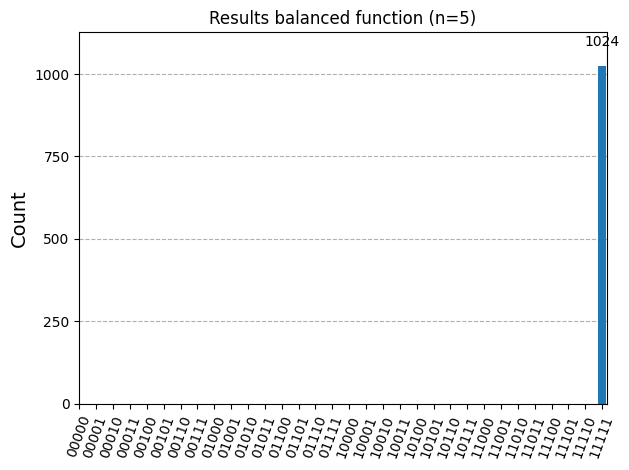

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator 
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline

def create_dj_oracle(n: int, case: str = "balanced") -> QuantumCircuit:
    """
    This function creates the oracle for the Deutsch-Jozsa algorithm.
    It implements a balanced or constant function based on the input case.
    """
    oracle_qc = QuantumCircuit(n + 1, name=f"Oracle ({case})")

    if case == "balanced":
        # i choose f(x) = x mod 2 as a balanced function
        for i in range(n):
            oracle_qc.cx(i, n)
    elif case == "constant":
        # or f(x) = 0 as a constant function
        pass
    else:
        raise ValueError("Should be 'balanced' or 'constant' only.")

    return oracle_qc


def create_deutsch_jozsa_circuit(n: int, case: str = "balanced") -> QuantumCircuit:
    """
    This function creates the Deutsch-Jozsa circuit using the specified number of qubits (n) of an first register
    and the type of function (case) to be tested: 'balanced' or 'constant to define the oracle block
    """
    qc = QuantumCircuit(n + 1, n)
    qc.h(range(n))
    qc.x(n)
    qc.h(n)
    qc.barrier()
    
    oracle = create_dj_oracle(n, case)
    qc = qc.compose(oracle)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc


def main():
    """main function to run the Deutsch-Jozsa algorithm simulation."""
    n = 5  # here we define the number of qubits in the first register (pls don't use more than 20)
    function_type = "balanced"  # here the type of function could be defined: 'balanced' or 'constant'

    # Create the Deutsch-Jozsa circuit with the specified parameters
    dj_circuit = create_deutsch_jozsa_circuit(n, function_type)
    print(f"--- Circuit for n={n} and {function_type} function ---")
    print(dj_circuit)


    # 1. Initializing the AerSimulator
    simulator = AerSimulator()

    # 2. Transpiling the circuit for the simulator
    #    This step optimizes the circuit for the specific backend (simulator in this case)
    transpiled_circuit = transpile(dj_circuit, simulator)

    # 3. Submitting the circuit to the simulator for execution
    job = simulator.run(transpiled_circuit, shots=1024)

    # 4. getting the result of the job
    result = job.result()

    # 5. getting the counts of the results
    counts = result.get_counts(transpiled_circuit)
    

    # visualize the results
    print(f"\n--- Results ---")
    print(f" > Number of measurements: {counts}") 

    most_likely_outcome = max(counts, key=counts.get)
    
    print("\n--- Decision ---")
    if all(bit == '0' for bit in most_likely_outcome):
        print(f"✅ Result '{most_likely_outcome}' is zero vector. Function is constant.")
    else:
        print(f"✅ Result '{most_likely_outcome}' is nonzero. Function is balanced.")
    
    # Visualize the results using a histogram
    all_outcomes = [''.join(bits) for bits in product('01', repeat=n)]
    for outcome in all_outcomes:
        if outcome not in counts:
            counts[outcome] = 0

    plot_histogram(counts, title=f"Results {function_type} function (n={n})", sort='asc')
    plt.show()


if __name__ == "__main__":
    main()